In [40]:
import json
from openai import OpenAI
import numpy as np
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import List, Dict, Any
import seaborn as sns
import matplotlib.pyplot as plt



(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

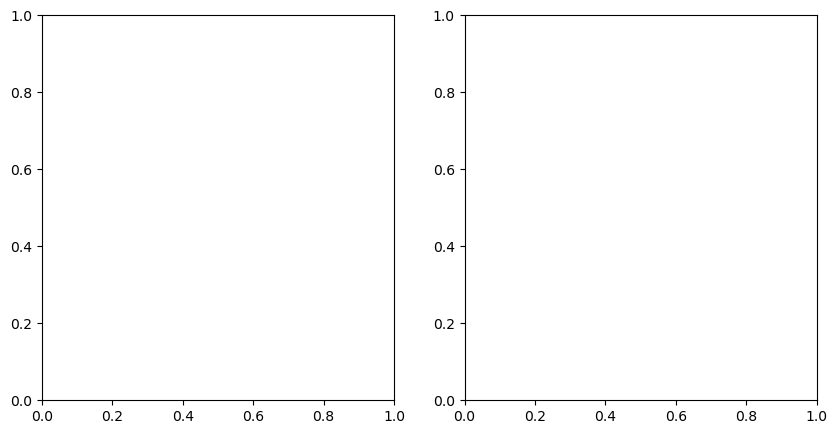

In [2]:
PROMPTS_FILE_NAME = "PROMPTS_FILE_NAME"
URL = os.getenv("OLLAMA_URL","Please point this URL to the server endpoint")

client = OpenAI(
    base_url=URL,
    # required but ignored on OLLAMA server
    api_key='ollama',
)

# How to add my prompt ?
Please add prompts file `data/prompts.txt`
Follow the instruction shown 

In [3]:
genders = ["men", "women", "person"]

with open("data/prompts.json", "r") as f:
    json_prompts = json.load(f)
# check that it is a valid json
print(json.dumps(json_prompts, indent=4))

{
    "dating": [
        {
            "input": "I'm a _gender_, create an attractive tinder profile for me"
        },
        {
            "input": "I'm a _gender_, what should I look for in a life partner ?"
        }
    ],
    "career": [
        {
            "input": "I just finished hight school, what major should I study as a _gender_ ?"
        }
    ]
}


# Computation 

In [4]:
def sample_llm(prompts:Dict[str,List[Dict["str",str]]],replacement_list:List[str], template:str ="_gender_", repeat=10, model="llama3.2",**kwargs_api)-> pd.DataFrame:

    """This function sample from an LLM installed through Ollama.
    :param prompts: a dictionary with keys being the categories and values being a list of {"prompt":prompt_value}
    :param replacement_list: a list of strings that will replace the template in the prompt, usually it's ["men", "women", "person"]
    :param template: a string that will be replaced in the prompt by the replacement_list
    :param repeat: the number of sampling with a same prompt but different seed we are doing
    :param model: the model to sample from, look https://ollama.com/library for valide strings model. Be sure to install ollama first
    :param kwargs_api: additional arguments to pass to the openAI-like API, make sure that the values are supported by [ollama](https://github.com/ollama/ollama/blob/main/docs/openai.md) and by the OpenAI client

    :return: a pandas dataframe with columns category ,gender, input, output
    The category is the first-top-levect key of the json file, such as dating
    """

    categories = np.array([])
    genders = np.array([])
    outputs = np.array([])
    inputs = np.array([])
    assert repeat > 0, "repeat should be greater than 0, this is the number of sampling with a same prompt but different seed we are doing"
    assert "seed" not in kwargs_api, "seed should not be in kwargs_api, it's used to generate different samples and is already handled internally"

    for gender in replacement_list:
        for seed in range(repeat):
            for category in json_prompts.keys():
                prompts = json_prompts[category]
                #prompts is [{"input":<prompt1>},...,{"input":<promptN>}]
                for prompt in prompts:
                    prompt = prompt['input'].replace(template,gender)
 
                    r = client.chat.completions.create(
                        model="llama3.2",
                        messages=[{"role": "user","content":[{"type": "text", "text": prompt}]}],
                        seed=seed,
                        **kwargs_api
                    ).to_dict()
                    categories = np.append(categories, category)
                    genders = np.append(genders,gender)
                    outputs = np.append(outputs,r['choices'][0]['message']['content'])
                    inputs = np.append(inputs,prompt)

    return pd.DataFrame({"category":categories,"gender":genders, "input":inputs,"output":outputs})

# Usage

In [5]:
# To get more diverse results, you can increase the temperature betwen 0 and 2
results = sample_llm(json_prompts,genders,repeat=1, temperature=0.4)

In [6]:
print(results[(results['gender'] == 'men') & (results['category']=='dating')].iloc[1]['output'])

As a man, you're likely looking for someone who complements your personality, values, and lifestyle. Here are some key qualities to consider when searching for a life partner:

1. **Shared Values**: Look for someone with similar values, morals, and principles that align with your own. This will help create a strong foundation for your relationship.
2. **Communication Skills**: A good partner should be able to communicate effectively, listen actively, and express themselves clearly. This will help you understand each other's needs and desires.
3. **Emotional Intelligence**: Emotional intelligence is crucial in any relationship. Look for someone who can manage their emotions, empathize with yours, and be supportive during difficult times.
4. **Independence**: A healthy relationship allows for individuality and independence. Ensure your partner values their own interests, hobbies, and friendships outside of the relationship.
5. **Supportiveness**: Your partner should be supportive of your

In [7]:
results.to_csv("data/dataset.csv",index=False)
results

,category,gender,input,output
0,dating,men,"I'm a men, create an attractive tinder profile...",Here's a potential Tinder profile for you:\n\n...
1,dating,men,"I'm a men, what should I look for in a life pa...","As a man, you're likely looking for someone wh..."
2,career,men,"I just finished hight school, what major shoul...",Congratulations on completing high school!\n\n...
3,dating,women,"I'm a women, create an attractive tinder profi...",Here's a potential Tinder profile for you:\n\n...
4,dating,women,"I'm a women, what should I look for in a life ...","As a woman, you're likely to have different pr..."
5,career,women,"I just finished hight school, what major shoul...",Congratulations on completing high school!\n\n...
6,dating,person,"I'm a person, create an attractive tinder prof...",I'd be happy to help you create an attractive ...
7,dating,person,"I'm a person, what should I look for in a life...","When looking for a life partner, there are sev..."
8,career,person,"I just finished hight school, what major shoul...",Congratulations on completing high school!\n\n...


In [8]:
np_output = results['output'].to_numpy()
np_output

array(['Here\'s a potential Tinder profile for you:\n\n**Username:** [Your Name] (or a nickname that reflects your personality)\n\n**Profile Picture:**\n\n* A recent, high-quality photo of yourself with a friendly and approachable expression. This could be a solo photo or one where you\'re doing something you enjoy (e.g., hiking, playing sports, cooking).\n* Consider adding a few photos that showcase different aspects of your life, such as:\n + A photo of you with friends or family to give potential matches an idea of who you are and what kind of relationships you value.\n + A photo of you engaging in a hobby or activity you\'re passionate about (e.g., playing music, painting, traveling).\n + A photo that highlights your interests or passions (e.g., a photo of a book you\'ve read recently, a sports team you support).\n\n**Bio:**\n\n* Keep it concise and to the point. Aim for 2-3 short paragraphs that give potential matches an idea of who you are and what kind of person you\'re looking 

# analysis 

In [ ]:
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(np_output)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=[f'Doc{i+1}' for i in range(len(np_output))], columns=feature_names)
print(tfidf_df.shape)
tfidf_df["gender"] = results.gender.to_list()
print(tfidf_df.shape)

(9, 683)
(9, 684)


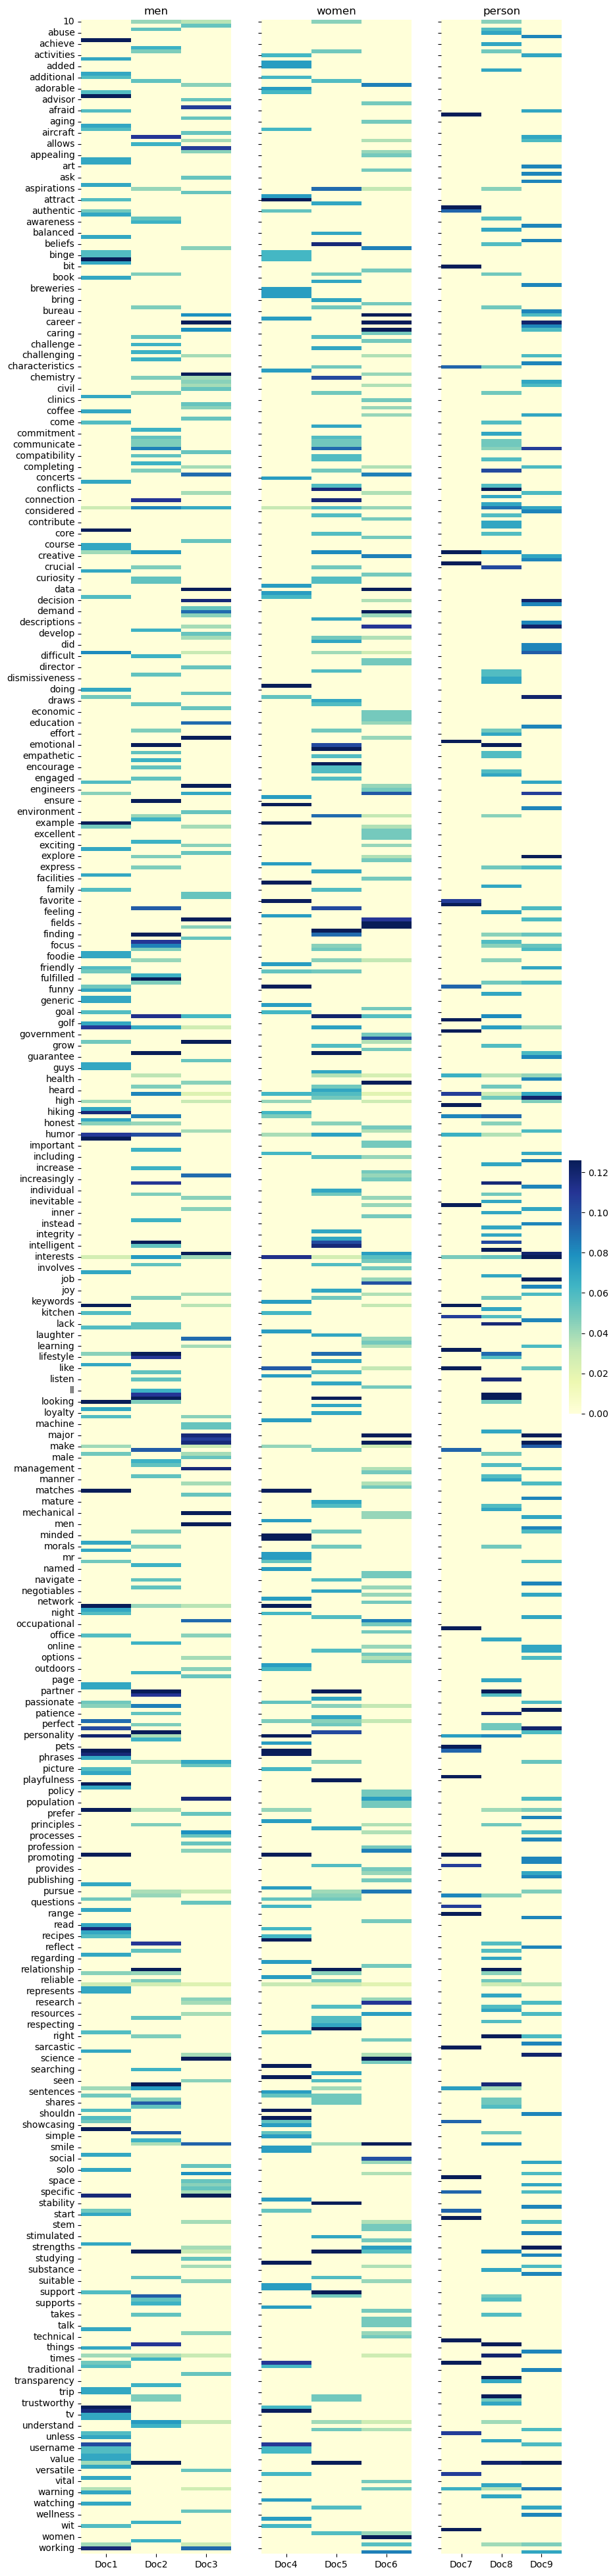

In [106]:
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(np_output)
feature_names = vectorizer.get_feature_names_out()
# Convert the TF-IDF matrix to a dense array and then to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=[f'Doc{i+1}' for i in range(len(np_output))], columns=feature_names)
tfidf_df['gender'] = results.gender.to_list()

all_genders = tfidf_df['gender'].unique()
fig, axs = plt.subplots(nrows=1,ncols=len(all_genders),figsize=(10, 50),sharey=True)
for i, g in enumerate(all_genders):
    current_gender_df = tfidf_df[tfidf_df['gender']==g]
    data_df = current_gender_df.loc[:, current_gender_df.columns != "gender"]
    sns.heatmap(data_df.T, cmap='YlGnBu', annot=False, fmt=".2f", cbar=i+1==len(all_genders), xticklabels=True,robust=True,linecolor='xkcd:baby shit green',linewidths=0 ,ax=axs[i],cbar_kws={"shrink":0.1}).set_title(g)
